In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import sklearn.metrics as metrics
from statistics import mean
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from scipy import stats

# EDA

In [3]:
rawData = pd.read_csv('problem_dataset.csv', delimiter='|',index_col=0,parse_dates=[1,7])
print(rawData.head())
print(rawData.info())
print(rawData.isnull().sum())

             ArrivalDate    Age  ShopID  IsHeavy  CarModelID  CommodityID  \
ShopRecordID                                                                
1             2017-06-27   8.49  471553     True      292204       477991   
2             2017-10-10   7.86  471554     True      292205       477992   
3             2017-10-10   4.32  471555    False      292206       477993   
4             2017-10-04  10.10  471556    False      292207       477994   
5             2017-10-18   9.64  471556     True      292207       477995   

             DateCompleted  
ShopRecordID                
1               2018-01-02  
2               2018-02-24  
3               2018-01-24  
4               2018-06-15  
5               2018-02-16  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7264 entries, 1 to 7264
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ArrivalDate    7264 non-null   datetime64[ns

In [4]:
rawData['CycleTime'] = (rawData['DateCompleted'] - rawData['ArrivalDate']).dt.days
print(rawData['CycleTime'])

ShopRecordID
1       189
2       137
3       106
4       254
5       121
       ... 
7260     63
7261     29
7262     52
7263     34
7264     20
Name: CycleTime, Length: 7264, dtype: int64


- All records are valid
- Data is in tidy format
- Categorical/Factor: ShopID, IsHeavy, CarModelID, CommodityID
- Numeric: Age, CycleTime
- Dates: ArrivalDate, DateCompleted

#### "Use cars completed 1/1/2018 to 5/31/2019 as your training set"

In [5]:
rawData['DateCompleted'].min()

Timestamp('2018-01-01 00:00:00')

In [6]:
trainingData = rawData[(rawData['DateCompleted'] <= pd.to_datetime("2019-05-31"))].copy()
trainingData.head()

,ArrivalDate,Age,ShopID,IsHeavy,CarModelID,CommodityID,DateCompleted,CycleTime
ShopRecordID,,,,,,,,
1,2017-06-27,8.49,471553,True,292204,477991,2018-01-02,189
2,2017-10-10,7.86,471554,True,292205,477992,2018-02-24,137
3,2017-10-10,4.32,471555,False,292206,477993,2018-01-24,106
4,2017-10-04,10.10,471556,False,292207,477994,2018-06-15,254
5,2017-10-18,9.64,471556,True,292207,477995,2018-02-16,121


In [7]:
rawData[['Age','CycleTime']].describe()

,Age,CycleTime
count,7264.000000,7264.000000
mean,11.958941,95.064290
std,6.056070,78.067959
min,3.180000,0.000000
25%,9.500000,40.000000
50%,10.340000,74.000000
75%,11.930000,127.000000
max,43.820000,710.000000


# Analysis Plots

In [8]:
mpl.rcParams['figure.figsize'] = (20, 10)
sns.set(rc = {'figure.figsize':(20,10)})

#### Complete Data

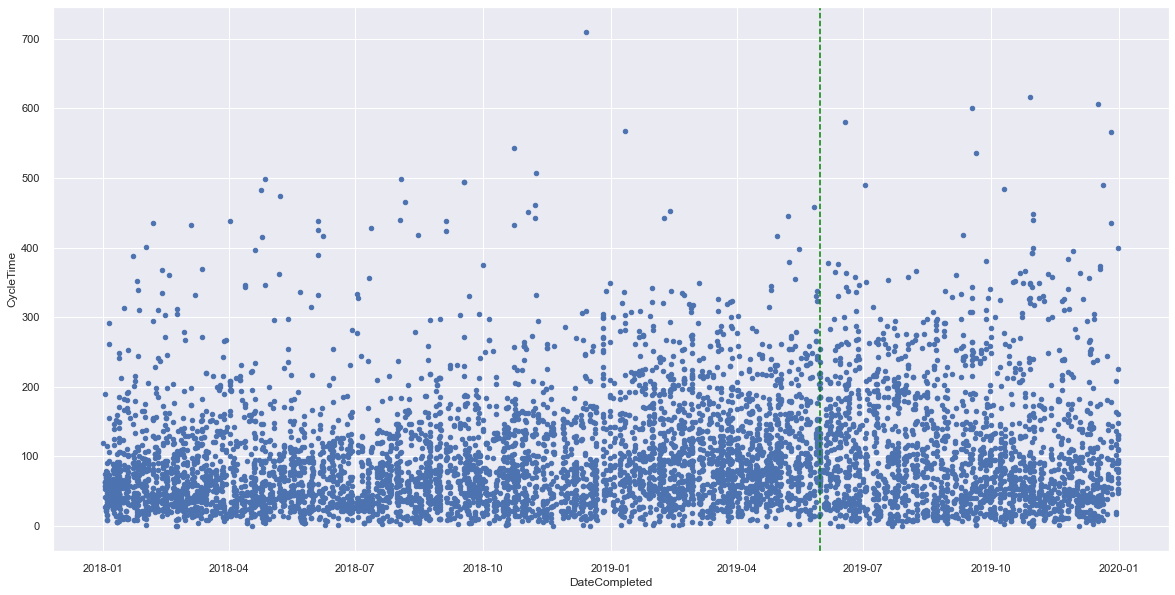

In [9]:
ax = rawData.plot.scatter(x = 'DateCompleted', y = 'CycleTime');
ax.axvline(pd.to_datetime("2019-05-31"), color="green", linestyle="dashed");

- CycleTimes seem to be consistant in the training/testing split

#### CycleTime

array([[<AxesSubplot:title={'center':'CycleTime'}>]], dtype=object)

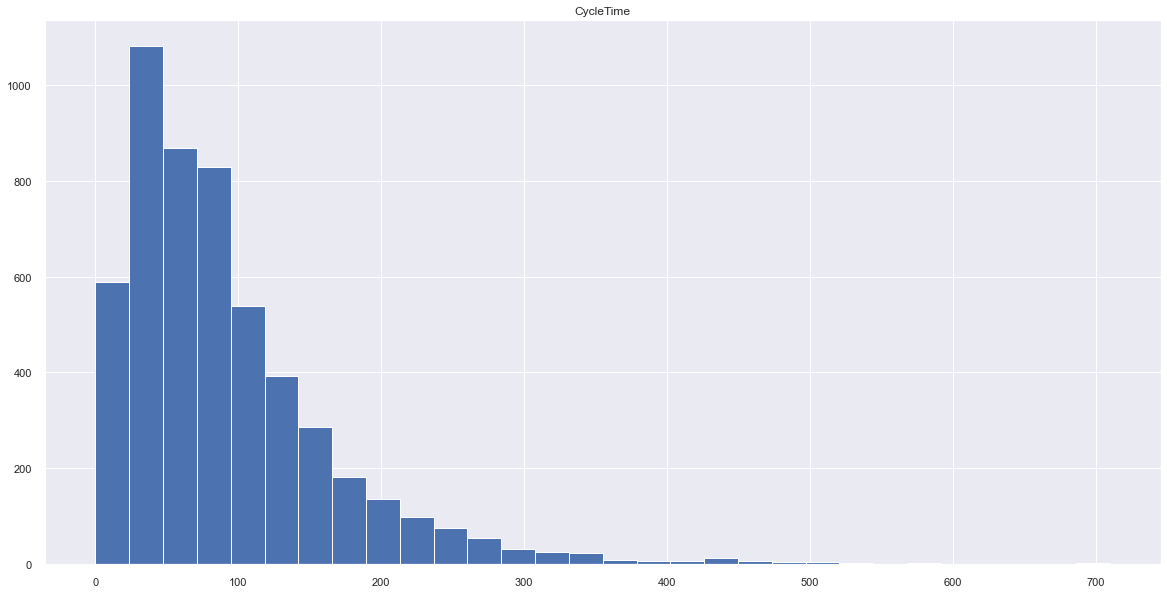

In [10]:
trainingData.hist('CycleTime', bins = 30)

- CycleTime is skewed right, transformations can be done to normalize this variable<br>

#### CycleTime - Log Transformation

array([[<AxesSubplot:title={'center':'LogCycleTime'}>]], dtype=object)

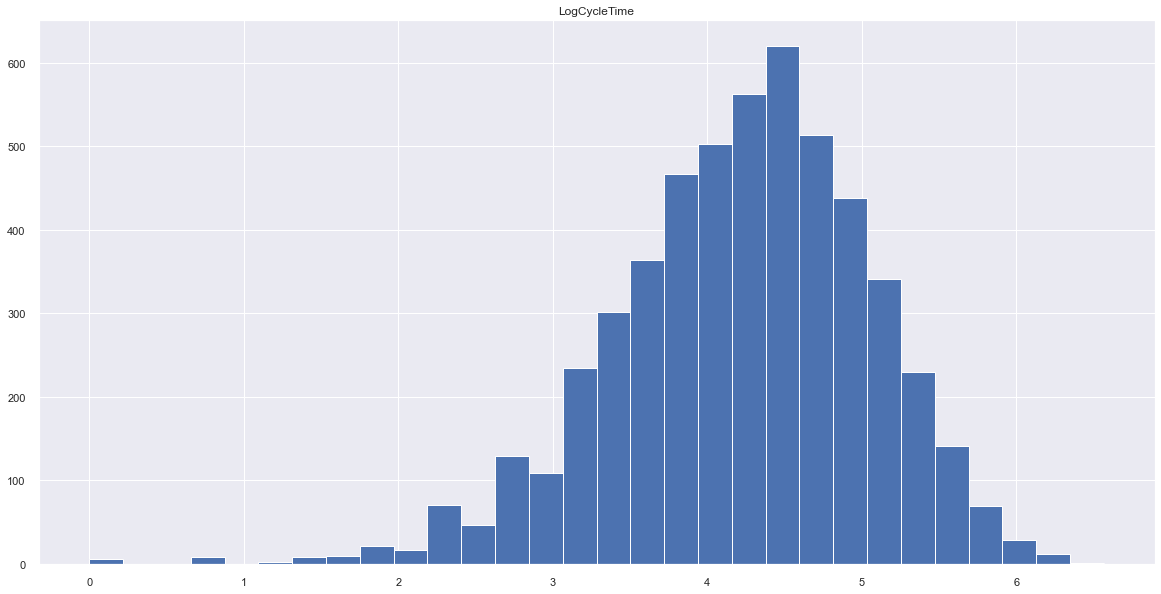

In [11]:
trainingData['LogCycleTime'] = np.log(trainingData['CycleTime']+1)
trainingData.hist('LogCycleTime', bins = 30)

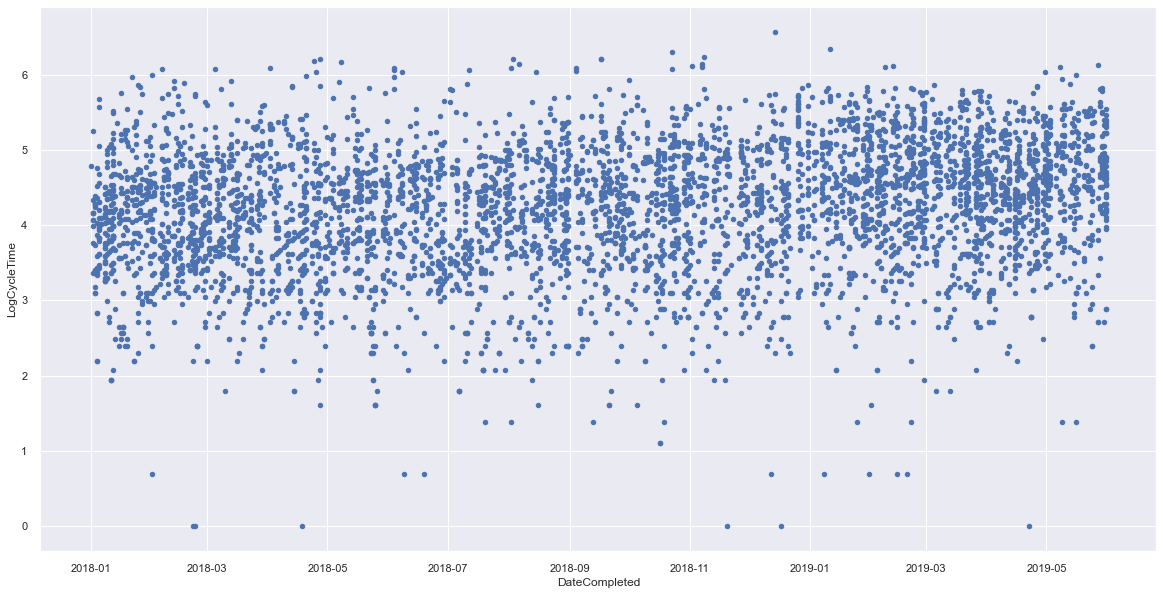

In [12]:
trainingData.plot.scatter(x = 'DateCompleted', y = 'LogCycleTime');

#### CycleTime - Square Root Transformation

array([[<AxesSubplot:title={'center':'RootCycleTime'}>]], dtype=object)

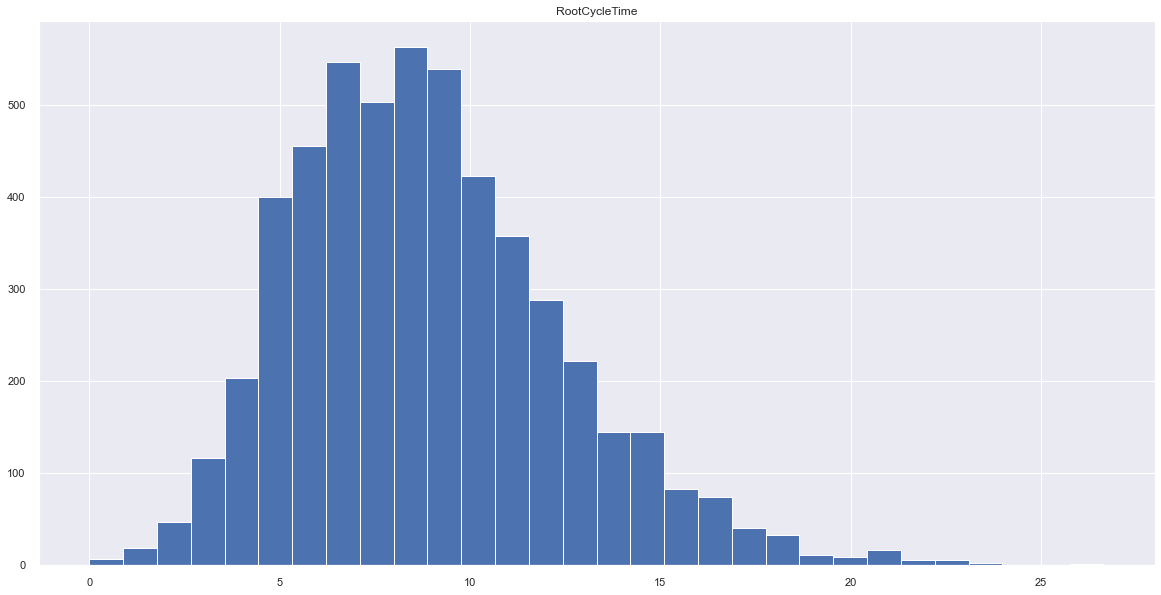

In [13]:
trainingData['RootCycleTime'] = np.sqrt(trainingData['CycleTime']);
trainingData.hist('RootCycleTime', bins = 30)

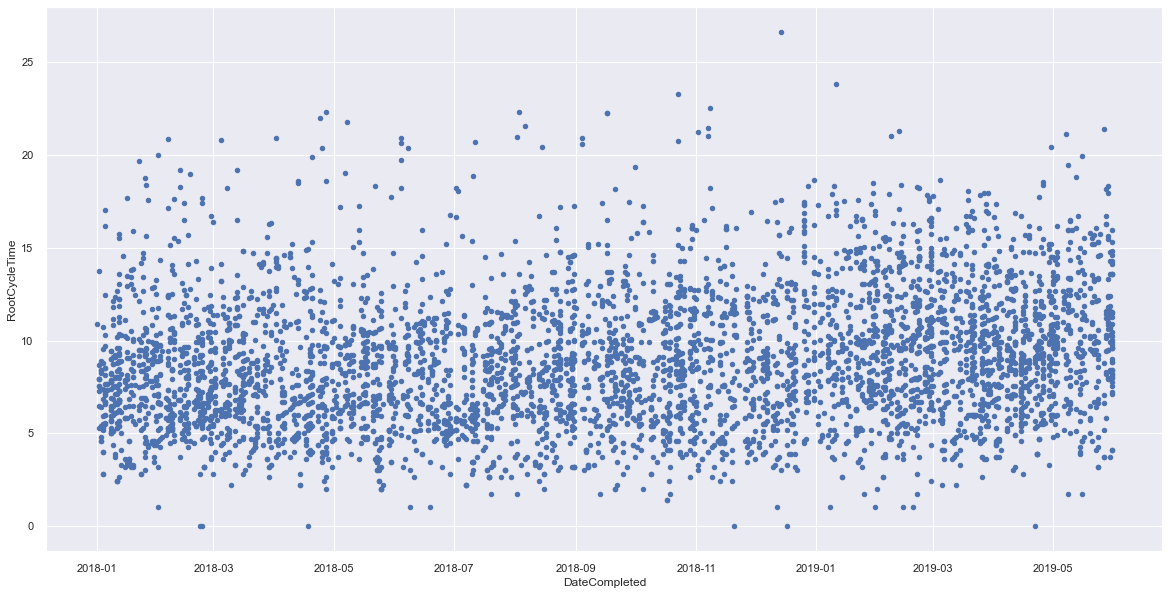

In [14]:
trainingData.plot.scatter(x = 'DateCompleted', y = 'RootCycleTime');

- Both log transformation and square root transformation help normalize this variable

#### IsHeavy

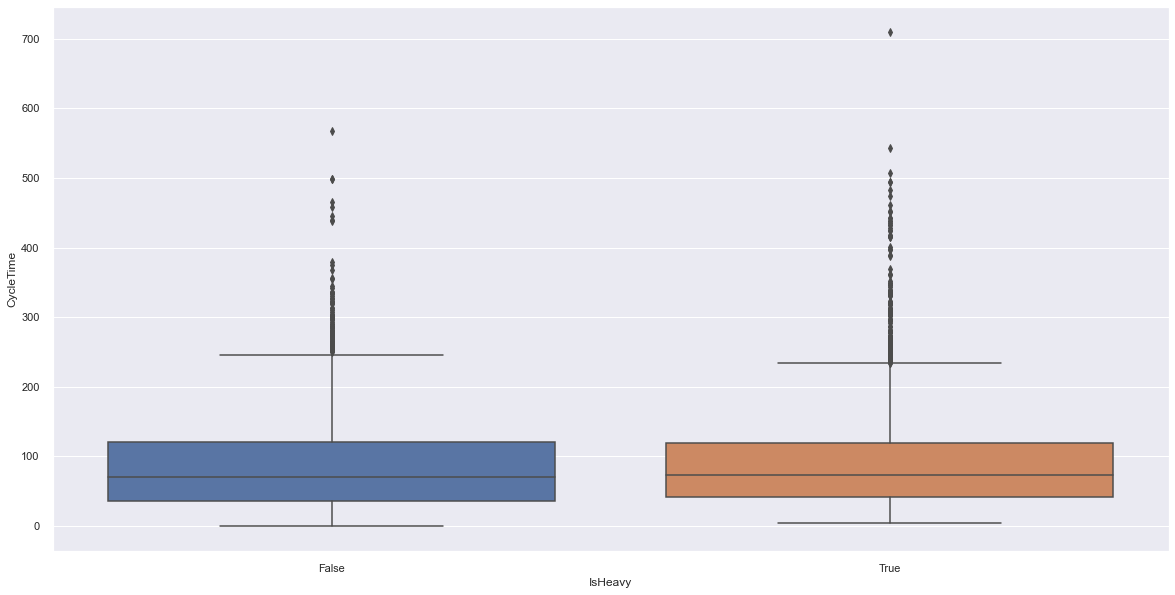

In [15]:
sns.boxplot(x = "IsHeavy", y = "CycleTime", data = trainingData);

In [16]:
trainingData.groupby('IsHeavy')['CycleTime'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
IsHeavy,,,,,,,,
False,1764.0,90.59,74.68,0.0,36.0,71.0,121.0,568.0
True,3488.0,90.91,71.33,4.0,42.0,74.0,119.0,710.0


- Quite a few outiers
- High standard deviation
- While IsHeavy does not seem to affect CycleTime on its own, it may have an interaction with other variables

#### ArrivalDate

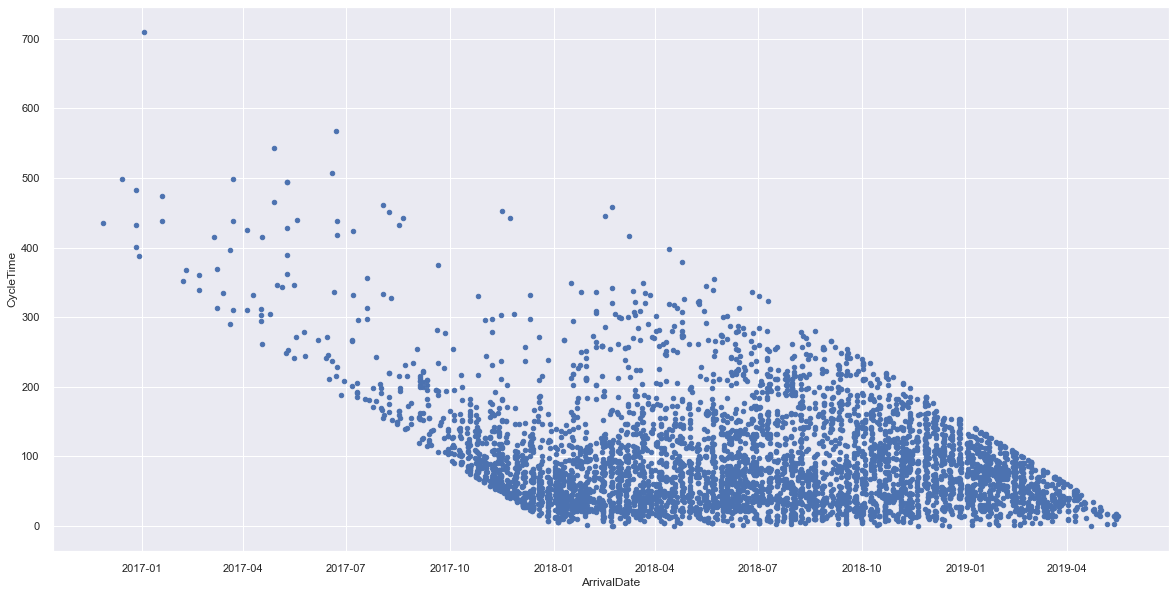

In [17]:
trainingData.plot.scatter('ArrivalDate','CycleTime');

- The shape of the plot indicates that there is a ceiling and floor effect
- The CycleTime of the car can only be at most max(DateCompleted) - ArrivalDate
- The CycleTime of the car can only be at least min(DateCompleted) - ArrivalDate

#### ArrivalDate - Month

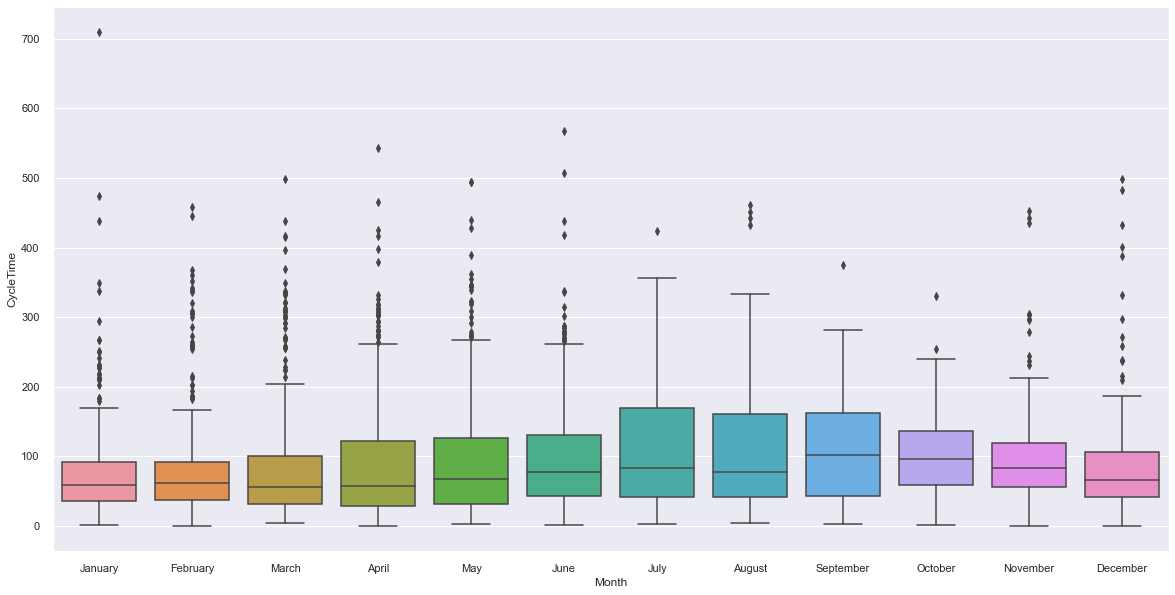

In [18]:
trainingData['Month'] = trainingData['ArrivalDate'].dt.month_name()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
trainingData['Month'] = pd.Categorical(trainingData['Month'], categories=months, ordered=True)
trainingData.sort_values(by = 'Month')
sns.boxplot(x = "Month", y = "CycleTime", data = trainingData);

- Months may still possess the same ceiling and floor effect that ArrivalDate shows

#### ArrivalDate - DayOfWeek

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,1143.0,81.02,67.80,0.0,32.00,63.0,108.00,507.0
Tuesday,1109.0,98.72,75.82,0.0,44.00,77.0,137.00,710.0
Wednesday,1052.0,90.00,68.36,0.0,42.00,75.0,118.00,495.0
Thursday,1165.0,95.54,75.48,0.0,43.00,76.0,125.00,568.0
Friday,630.0,91.86,76.13,0.0,40.00,75.5,118.75,543.0
Saturday,69.0,78.94,66.19,10.0,34.00,54.0,101.00,305.0
Sunday,84.0,65.75,48.72,4.0,29.75,48.5,97.00,262.0


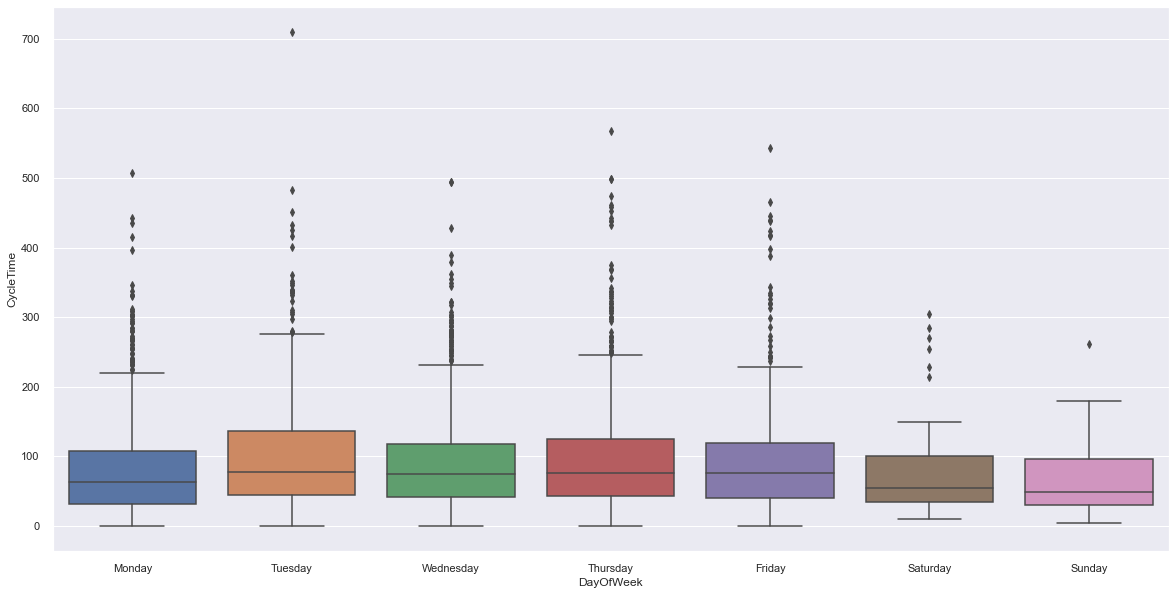

In [19]:
trainingData['DayOfWeek'] = trainingData['ArrivalDate'].dt.day_name()
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trainingData['DayOfWeek'] = pd.Categorical(trainingData['DayOfWeek'], categories=dayofweek, ordered=True)
trainingData.sort_values(by = 'DayOfWeek')
sns.boxplot(x = "DayOfWeek", y = "CycleTime", data = trainingData);
trainingData.groupby('DayOfWeek')['CycleTime'].describe().round(2)

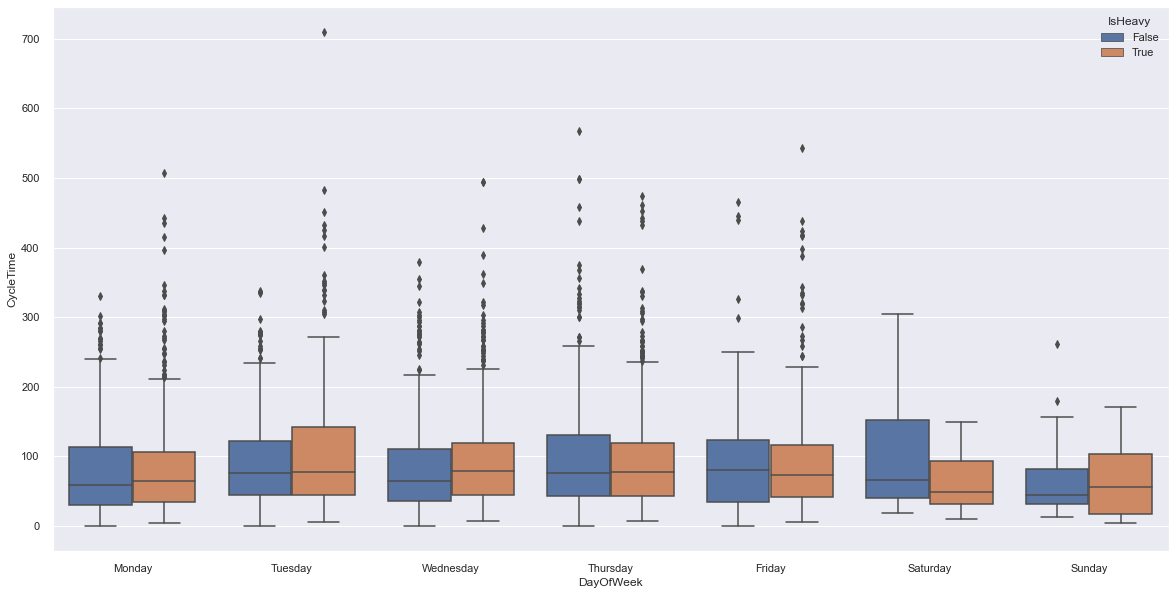

In [20]:
sns.boxplot(x = "DayOfWeek", y = "CycleTime", hue = 'IsHeavy', data = trainingData);

- DayOfWeek seems to have an effect on CycleTime
- There is no ceiling or floor effect using this metric

#### Age

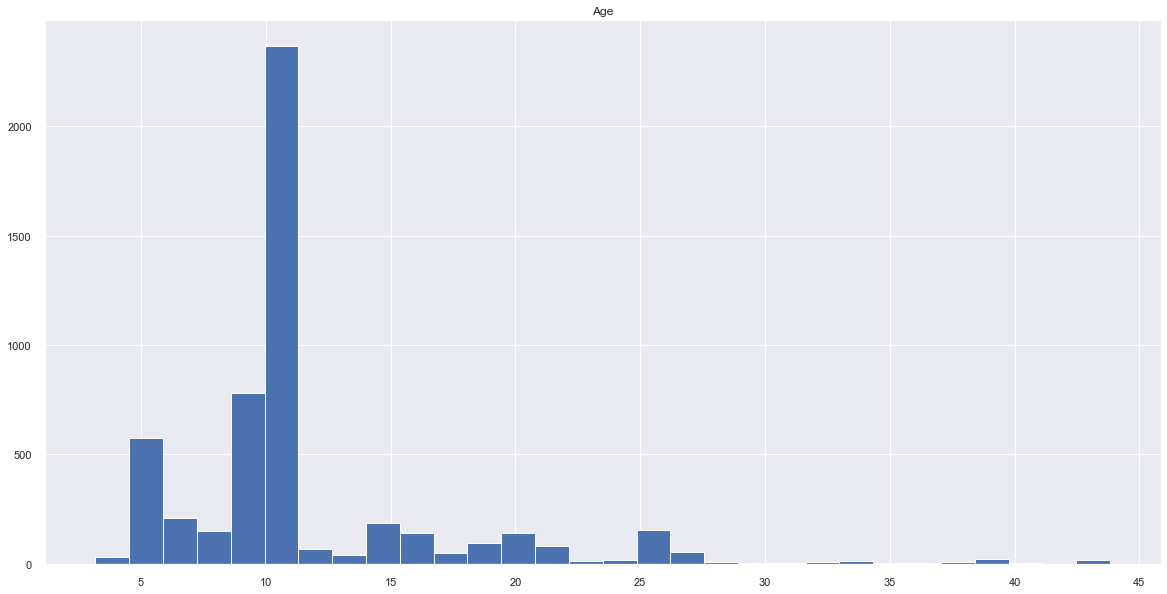

In [21]:
trainingData.hist('Age', bins = 30);

<AxesSubplot:xlabel='Age', ylabel='CycleTime'>

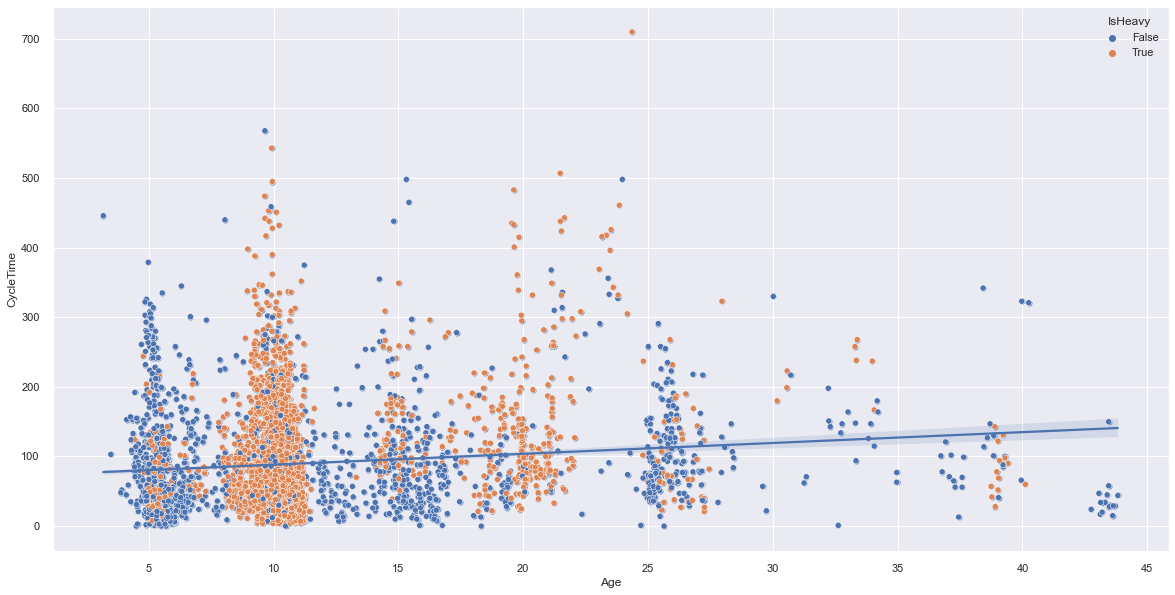

In [22]:
sns.regplot(x = 'Age', y = 'CycleTime', data = trainingData);
sns.scatterplot(x = 'Age', y = 'CycleTime', hue = 'IsHeavy', data = trainingData)

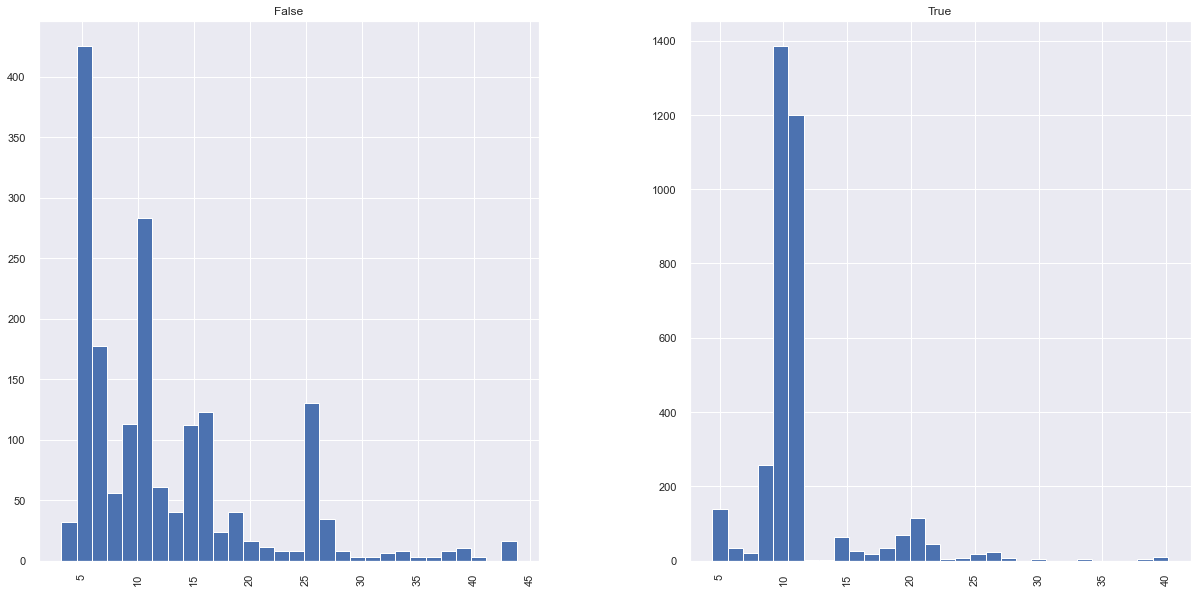

In [23]:
trainingData.hist('Age', by = 'IsHeavy', bins = 30);

,count,mean,std,min,25%,50%,75%,max
IsHeavy,,,,,,,,
False,1764.0,12.35,8.05,3.18,5.79,10.20,15.62,43.82
True,3488.0,11.27,4.15,4.44,9.90,10.34,10.78,40.12


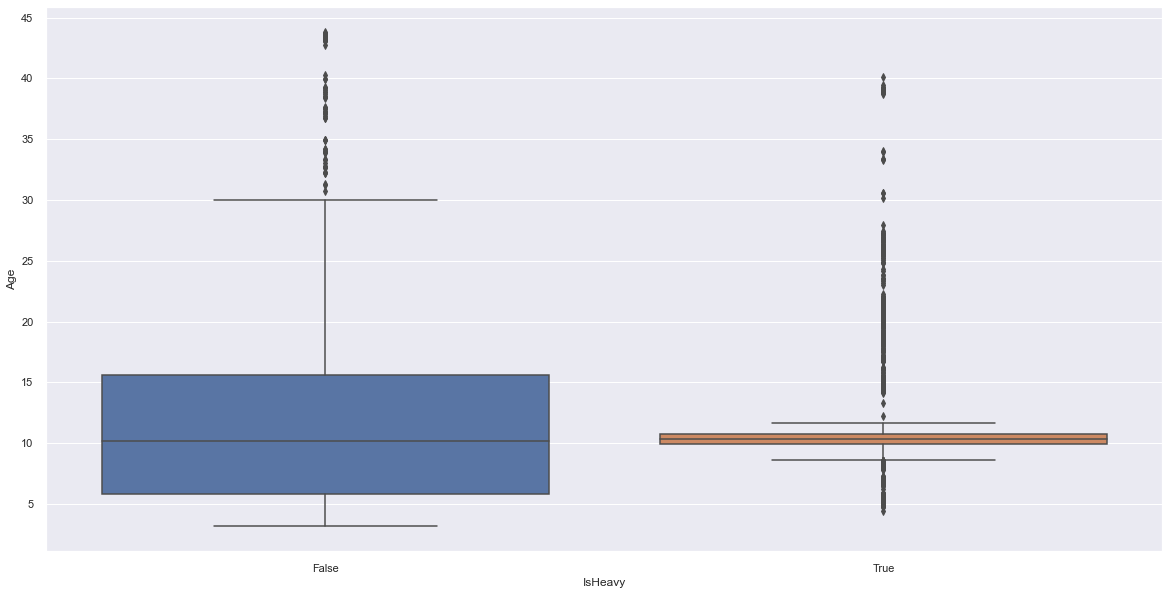

In [24]:
sns.boxplot(x = "IsHeavy", y = "Age", data = trainingData);
trainingData.groupby('IsHeavy')['Age'].describe().round(2)

- Age seems to be a factor in determining CycleTime
- Intresting interaction between IsHeavy and Age
- It seems that cars go into the shop at different ages depending on if they are heavy or not
- A transformation into the Age varible may be explored as the kurtosis is high (Leptokurtic)

#### Age - Log Transformation

In [25]:
rawData['Age'].min()

3.18

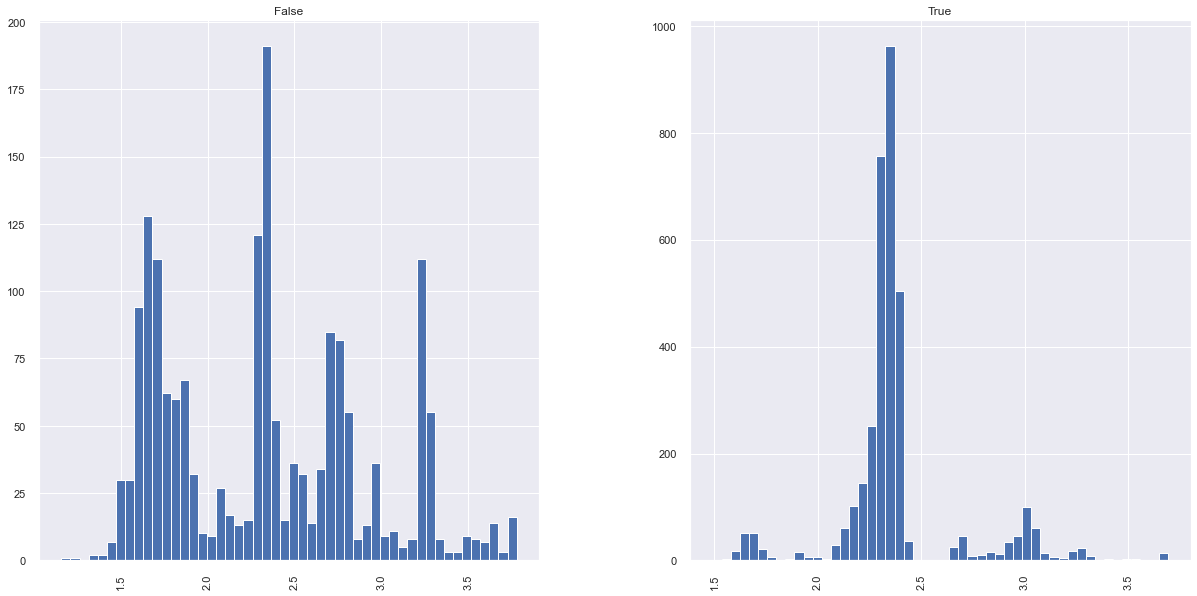

In [26]:
trainingData['LogAge'] = np.log(trainingData['Age'])
trainingData.hist('LogAge', by = 'IsHeavy', bins = 50);

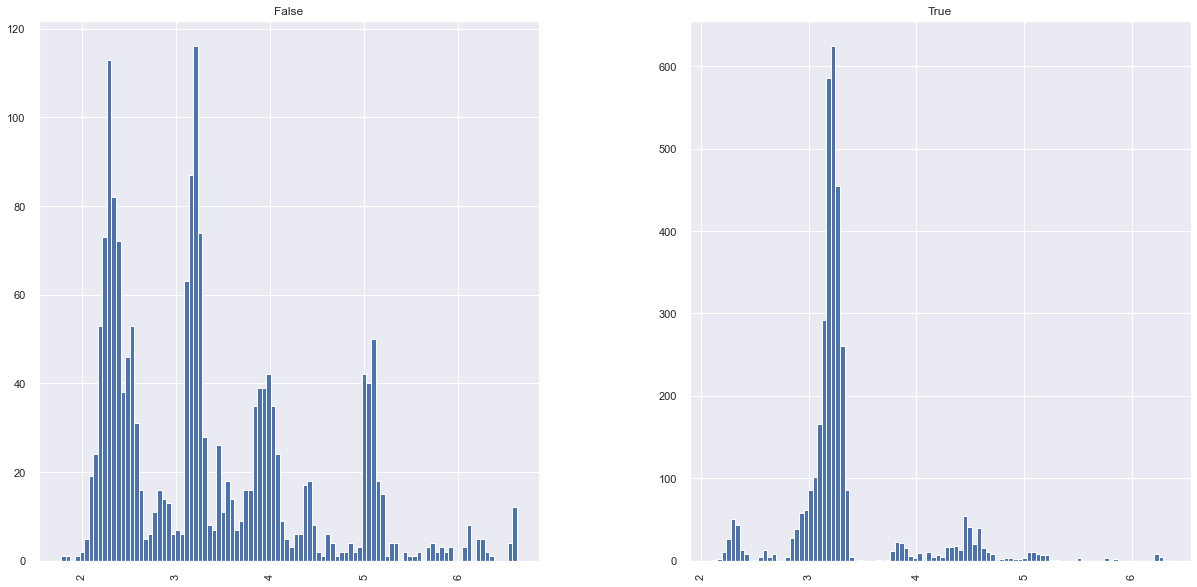

In [27]:
trainingData['RootAge'] = np.sqrt(trainingData['Age']);
trainingData.hist('RootAge', by = 'IsHeavy', bins = 100);

- The log transformation and root transformation do not fix the kurtosis of the plot
- Intresting multimodal distribution when IsHeavy is False

#### Categorical Variables (ShopID, CarModelID, CommodityID)

In [28]:
print("Unique Shops:", pd.unique(trainingData['ShopID']).shape[0])
print("Unique Cars:",pd.unique(trainingData['CarModelID']).shape[0])
print("Unique Commodities:",pd.unique(trainingData['CommodityID']).shape[0])

Unique Shops: 30
Unique Cars: 26
Unique Commodities: 294


#### ShopID

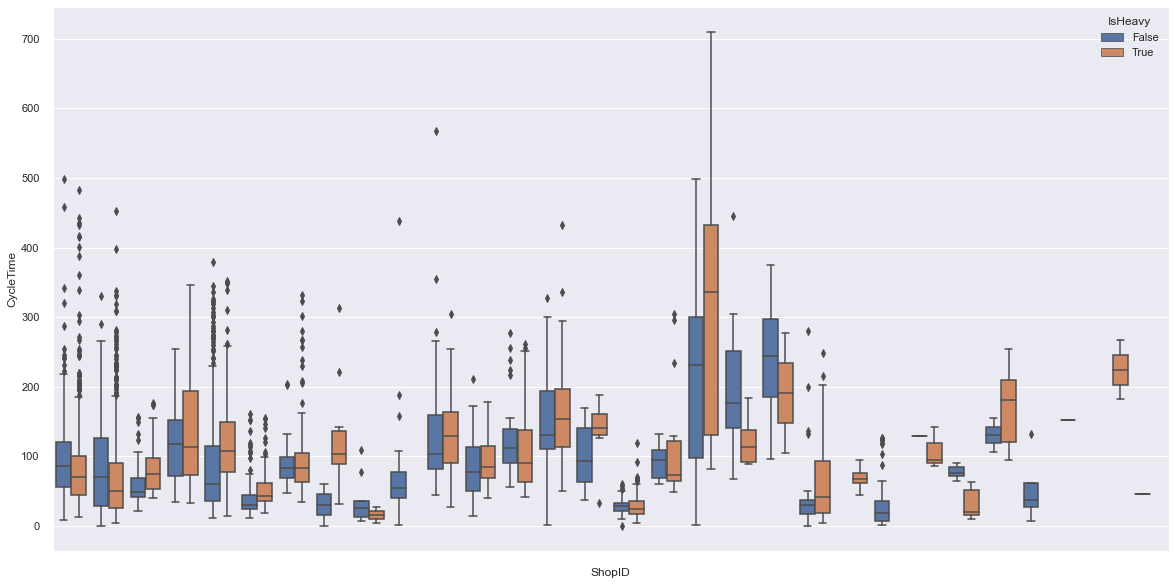

In [29]:
#ax = sns.relplot(data=trainingData,x="DateCompleted",y="CycleTime",col="ShopID",col_wrap=3)
#[plt.setp(ax.get_xticklabels(), rotation=30) for ax in ax.axes.flat];
#ax = sns.violinplot(x = "ShopID", y = "CycleTime", hue = "IsHeavy", split = True, data = trainingData).set(xticklabels=[])
ax = sns.boxplot(x = "ShopID", y = "CycleTime", hue = "IsHeavy", data = trainingData).set(xticklabels=[])

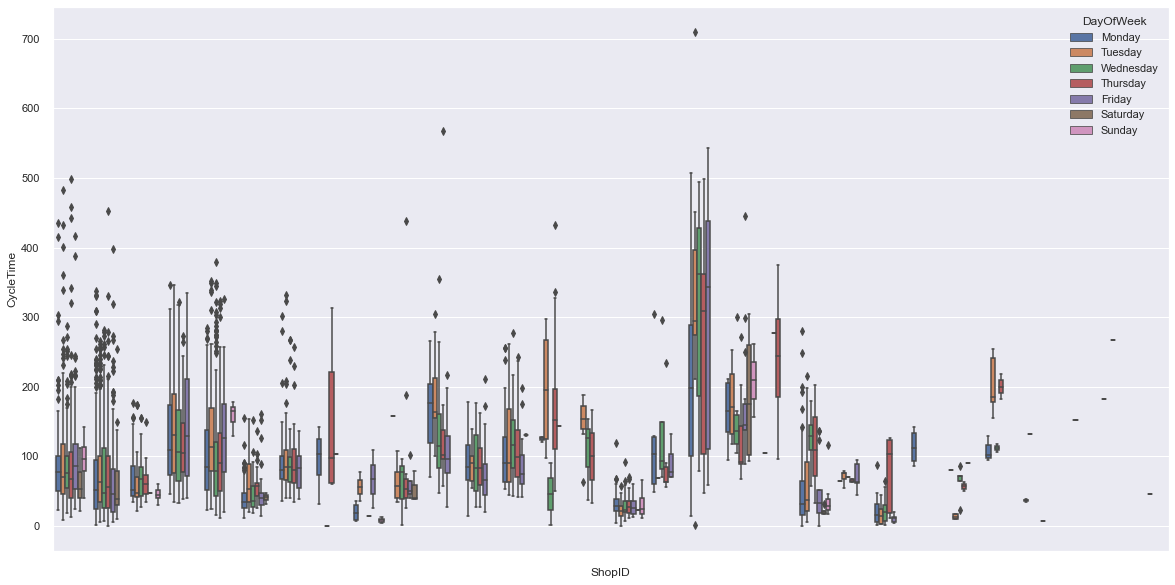

In [30]:
ax = sns.boxplot(x = "ShopID", y = "CycleTime", hue = "DayOfWeek", data = trainingData).set(xticklabels=[])

- ShopID seems to be a factor in determining CycleTime
- An interaction between ShopID and IsHeavy could be explored
- An interaction between ShopID and DayOfWeek could be explored

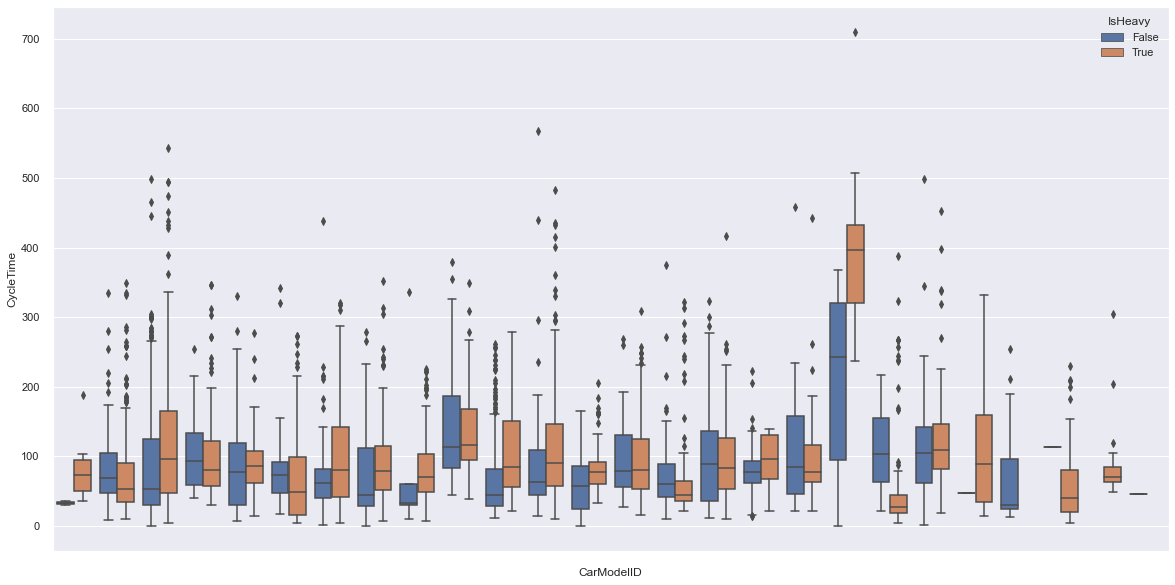

In [51]:
#ax = sns.relplot(data=trainingData,x="DateCompleted",y="CycleTime",col="CarModelID",col_wrap=3)
#[plt.setp(ax.get_xticklabels(), rotation=30) for ax in ax.axes.flat];
#ax = sns.violinplot(x = "CarModelID", y = "CycleTime", hue = "IsHeavy", split = True, data = trainingData).set(xticklabels=[])
ax = sns.boxplot(x = "CarModelID", y = "CycleTime", hue = "IsHeavy", data = trainingData).set(xticklabels=[])

- CarModelID seems to be a factor in determining CycleTime
- An interaction between CarModelID and IsHeavy could be explored

#### CommodityID

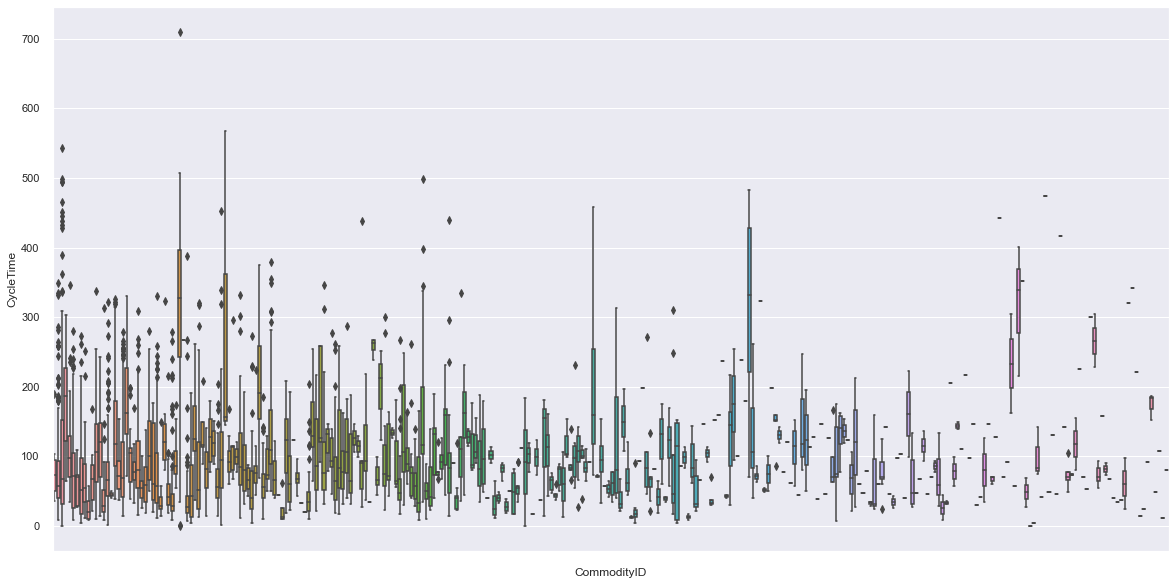

In [32]:
ax = sns.boxplot(x = "CommodityID", y = "CycleTime", data = trainingData).set(xticklabels=[])

- CommodityID seems to be a factor in determining CycleTime

# <b>Model Building

- DateCompleted should not be used to build a model
- ShopID, CarModelID, CommodityID, and Age should be considered in the model
- ArrivalDate should not be used to build the model, instead use DayOfWeek
- Explore interaction between IsHeavy and the other predictor variables

#### Set Up Dummy Variables

In [33]:
rawData['LogCycleTime'] = np.log(rawData['CycleTime']+1)

In [34]:
rawData['DayOfWeek'] = rawData['ArrivalDate'].dt.day_name()
dummyData = pd.get_dummies(rawData,prefix=['ShopID', 'CarModelID','CommodityID','DayOfWeek'], 
                           columns= ['ShopID', 'CarModelID','CommodityID','DayOfWeek']).copy()

In [48]:
trainDF = dummyData[(dummyData['DateCompleted'] >= pd.to_datetime("2018-01-01")) & (dummyData['DateCompleted'] <= pd.to_datetime("2019-05-31"))].copy()
trainDF['ArrivalDate'] = trainDF['ArrivalDate'].values.astype('float')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5252 entries, 1 to 7230
Columns: 407 entries, ArrivalDate to DayOfWeek_Wednesday
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), uint8(401)
memory usage: 2.3 MB


In [36]:
X = trainDF
X = X.drop(['CycleTime'],axis=1)
X = X.drop(['DateCompleted'],axis=1)
X = X.drop(['ArrivalDate'],axis=1)
X = X.drop(['LogCycleTime'],axis=1)
y = trainDF['CycleTime'].copy()
#y = trainDF['LogCycleTime'].copy()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
#X_inter = interaction.fit_transform(X)

<b>Ridge Regression

In [37]:
ridgemodel = RidgeCV(cv=cv, scoring='neg_mean_absolute_error')
ridgemodel.fit(X, y)
print('alpha: %f' % ridgemodel.alpha_)

alpha: 1.000000


<b>Lasso Regression

In [38]:
lassomodel = LassoCV(cv=cv)
lassomodel.fit(X,y)
print('alpha: %f' % lassomodel.alpha_)

alpha: 0.052021


<b>Elastic Net Regression

In [39]:
elasticmodel = ElasticNetCV(cv=cv)
elasticmodel.fit(X,y)
print('alpha: %f' % elasticmodel.alpha_)
print('l1_ratio_: %f' % elasticmodel.l1_ratio_)

alpha: 0.104042
l1_ratio_: 0.500000


## <b>Model Analysis

#### "Provide performance metrics (Mean Absolute Error & Root Mean Square Error) for cars completed 6/1/2019 to 12/31/2019."

In [40]:
testDF = dummyData[(dummyData['DateCompleted'] >= pd.to_datetime("2019-06-01")) & (dummyData['DateCompleted'] <= pd.to_datetime("2019-12-31"))].copy()
testDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012 entries, 23 to 7264
Columns: 407 entries, ArrivalDate to DayOfWeek_Wednesday
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), uint8(401)
memory usage: 884.2 KB


In [41]:
testX = testDF
testX = testX.drop(['CycleTime'],axis=1)
testX = testX.drop(['LogCycleTime'],axis=1)
testX = testX.drop(['DateCompleted'],axis=1)
testX = testX.drop(['ArrivalDate'],axis=1)
#testY = testDF['LogCycleTime'].copy()
testY = testDF['CycleTime'].copy()

<b>Baseline

In [42]:
meanTestCycle = mean(testDF['CycleTime'])
MTCArray = [meanTestCycle] * testY.size

baseMAE = metrics.mean_absolute_error(testY, MTCArray)
baseMSE = metrics.mean_squared_error(testY, MTCArray)
baseRMSE = np.sqrt(baseMSE) 
print("MAE: ", baseMAE)
print("RMSE: ", baseRMSE)

MAE:  69.50493263085504
RMSE:  90.14148407173425


<b>Ridge Regression

MAE:  53.476662263922854
RMSE:  79.53244194442524


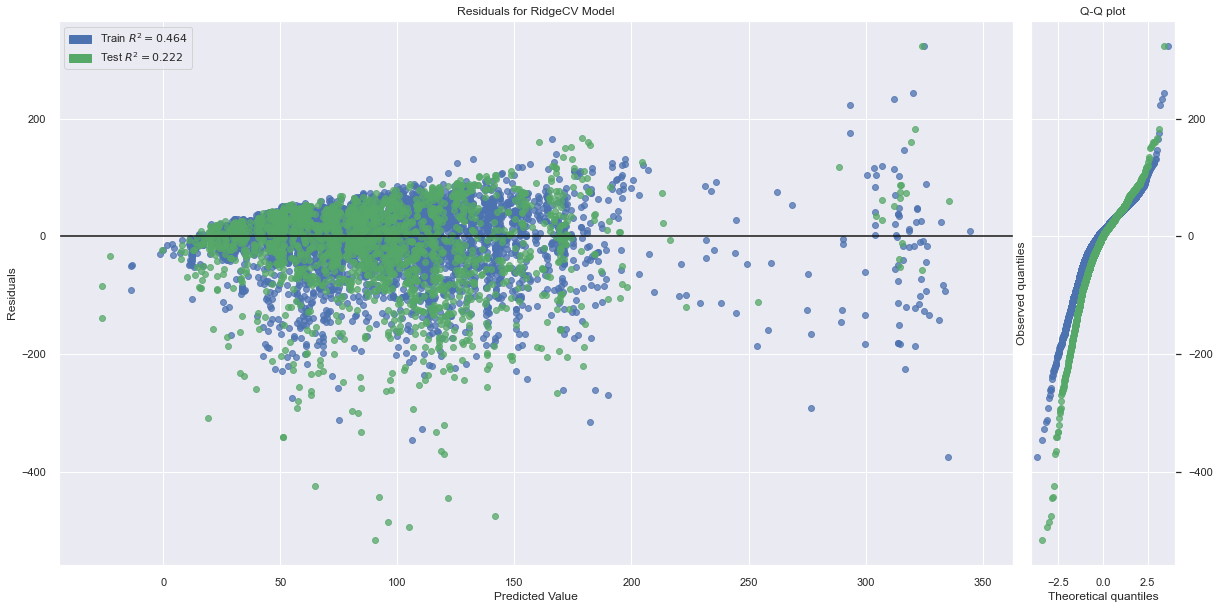

In [43]:
ridgeYhat = ridgemodel.predict(testX)
ridgeMAE = metrics.mean_absolute_error(testY, ridgeYhat)
ridgeMSE = metrics.mean_squared_error(testY, ridgeYhat)
ridgeRMSE = np.sqrt(ridgeMSE) 
print("MAE: ", ridgeMAE)
print("RMSE: ", ridgeRMSE)
visualizer = residuals_plot(RidgeCV(), X, y, testX, testY, qqplot = True, hist = False)

<b>Lasso Regression

MAE:  54.7936328986723
RMSE:  80.29037205837902


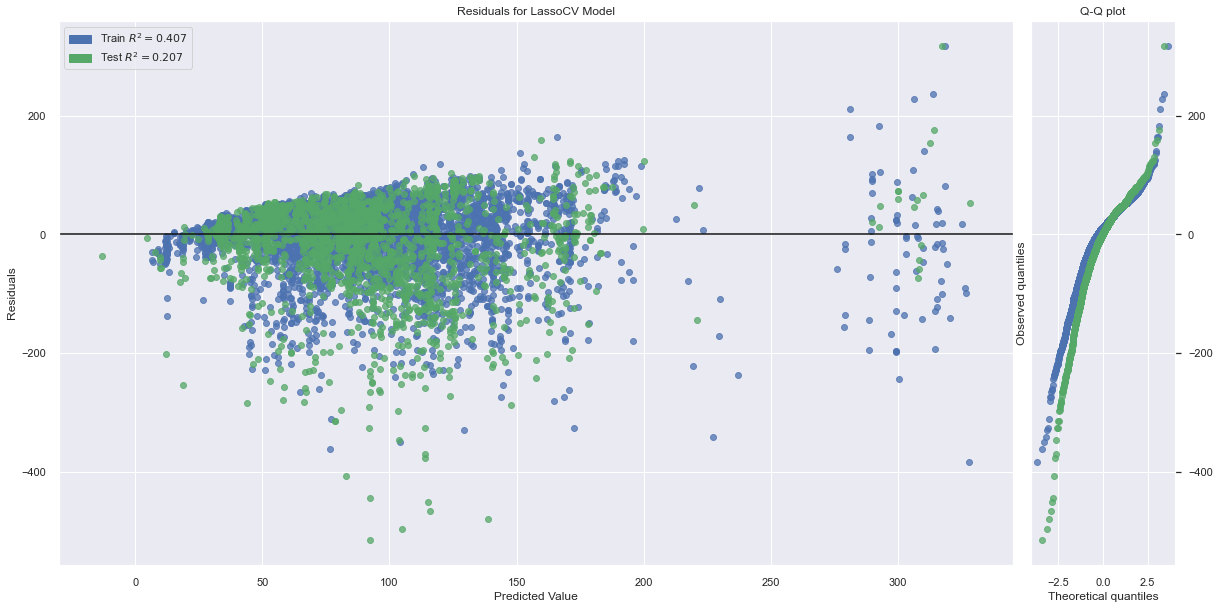

In [44]:
lassoYhat = lassomodel.predict(testX)
lassoMAE = metrics.mean_absolute_error(testY, lassoYhat)
lassoMSE = metrics.mean_squared_error(testY, lassoYhat)
lassoRMSE = np.sqrt(lassoMSE) 
print("MAE: ", lassoMAE)
print("RMSE: ", lassoRMSE)
visualizer = residuals_plot(LassoCV(), X, y, testX, testY, qqplot = True, hist = False)

<b>Elastic Net Regression

MAE:  60.92418240312228
RMSE:  84.83835997138321


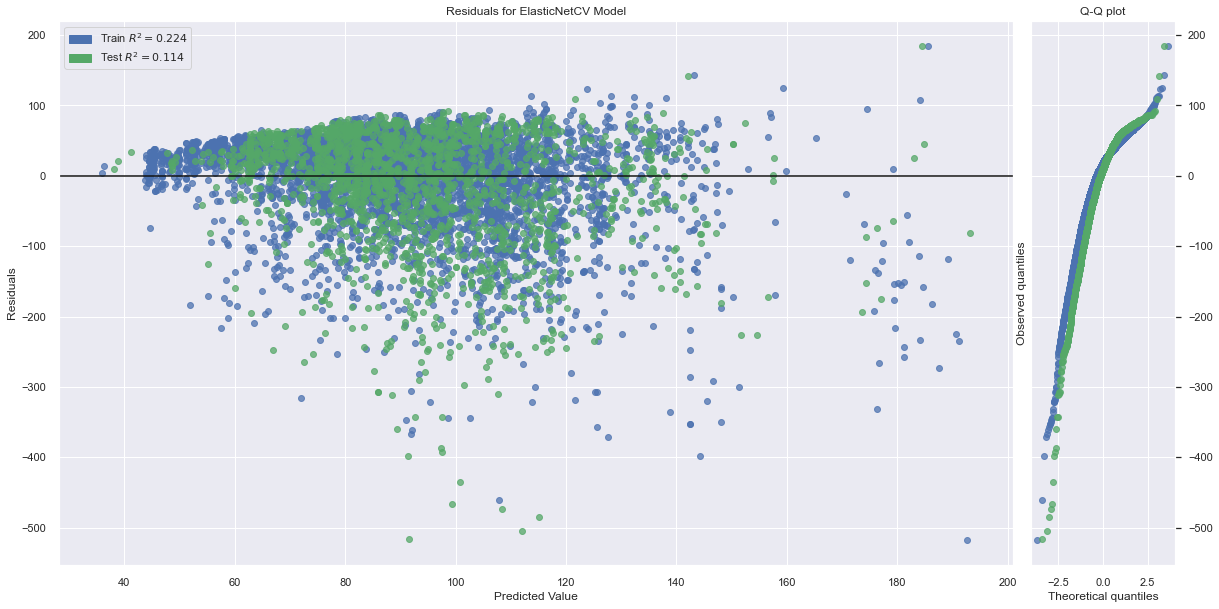

In [45]:
elasticYhat = elasticmodel.predict(testX)
elasticMAE = metrics.mean_absolute_error(testY, elasticYhat)
elasticMSE = metrics.mean_squared_error(testY, elasticYhat)
elasticRMSE = np.sqrt(elasticMSE) 
print("MAE: ", elasticMAE)
print("RMSE: ", elasticRMSE)
visualizer = residuals_plot(ElasticNetCV(), X, y, testX, testY, qqplot = True, hist = False)

- All three models show signs of violating the homoscedasticity assumption

# Outlier Robust Regressions

- The assumption of homoscedasticity is violated in the previous models, so other models must be eplored

#### SGDRegressor (Huber loss)

In [46]:
SGDModel = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3, loss = 'huber'));
SGDModel.fit(X, y);

MAE:  58.19723776434043
RMSE:  90.11806888069101


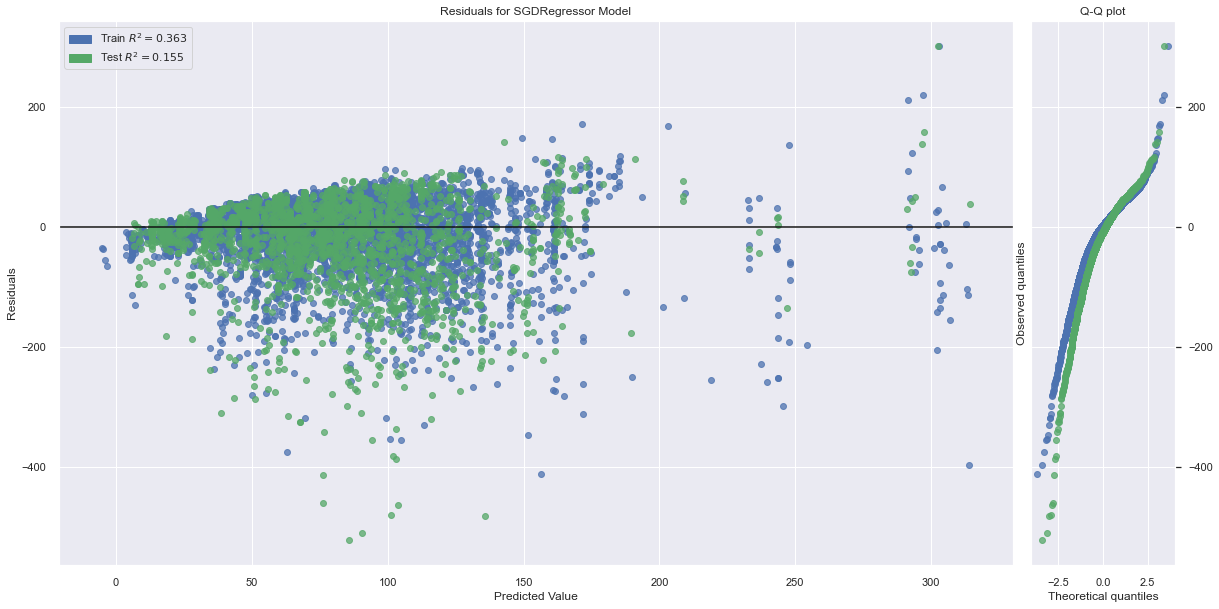

In [47]:
SGDYhat = SGDModel.predict(testX)
SGDMAE = metrics.mean_absolute_error(testY, SGDYhat)
SGDMSE = metrics.mean_squared_error(testY, SGDYhat)
SGDRMSE = np.sqrt(SGDMSE)
print("MAE: ", SGDMAE)
print("RMSE: ", SGDRMSE)
visualizer = residuals_plot(SGDRegressor(), X, y, testX, testY, qqplot = True, hist = False)

- Even with the huber loss, outliers still seem to affect the model

# Thoughts and Conclusions

In the end, these models are not able to predict the data effectively. Other models should be explored that take the many outliers into consideration. Regression models such as RANSAC may be able to solve the outlier problem. A non-parametric approach as well as bootstrapping may also be explored. Transformations, such as log, square root, or box-cox, on variables such as CycleTime or Age can help show trends within the data and reduce the effects of outliers. Interactions between variables such as Age and IsHeavy should also be considered, but too many interactions may be subject to the curse of dimensionality. The multimodal shape of the Age variable shoud also be studied.